# Degrees of Freedom Neuronaler Netze

Ablauf:
- Template Code bauen
- Einfaches Beispiel anschauen
- Simulationen um zu schauen inwiefern Finite Differences die Ergebnisse des Papers [[Jojic and Gao]] replizieren können.


# Genutzte Differences sind:

____

Forward Differences: $$ \dfrac{f(x + h) - (x)}{h} + O(h) $$
Backward Differences: $$ \dfrac{f(x) - (x - h)}{h} + O(h) $$
Centered Differences: $$ \dfrac{f(x + h) - (x - h)}{2 h} + O(h^2) $$
_____


# 0. Vorbereitungen
- Template Code erstellen.
- Schauen ob Seed gesetzt werden muss oder nicht bei wiederholtem Fitten.


## 0.1 OLS-Beispiel

Ein OLS Beispiel bauen um schnell einfachen Code zu schreiben für Finite Differences für Neuronale Netze.

### Libraries & Seed(s)

In [1]:
# System Libraries
import sys
import random
import copy
import time

# Costum Libraries
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import numpy as np
from numpy.linalg import inv
from tensorflow.python.ops.gen_array_ops import scatter_nd_eager_fallback
from tensorflow.python.ops.gen_logging_ops import timestamp
import matplotlib.pyplot as plt


In [2]:
# Set seed
random.seed(42)

### Daten Simulation

OLS Model mit der folgenden Form:
$$
    y = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \beta_3 x_3 + \beta_4 x_4 + \beta_5 x_5 + \beta_6 x_6 + \beta_7 x_7 + \beta_8 x_8 + \text{noise}, 
$$

hierbei werden 1000 ($n$) Beobachtungen simuliert, mit einem Noise $\sim N(0, 1)$ und allen Elemente für X als $x \sim N(0, 1)$.

In [3]:
n = 1000
residuals = np.random.normal(loc=0.0, scale=1, size=n)
residuals = residuals.reshape(n, 1)
betas = np.array((1, 2, 3, 4, 5, 6, 7, 8))
betas = betas.reshape(8,1)
x0 = np.ones(n)
x0 = x0.reshape(n, 1)
x = np.random.uniform(low=1, high=2, size =(n*7))
x = x.reshape(n, 7)
X = np.hstack((x0, x))
Xt = X.transpose()
Xb = np.matmul(X, betas)
y = Xb + residuals

### Grundmodell fitten

In [4]:
XtX = np.matmul(Xt, X)
XtX_inv = inv(XtX)
Xty = np.matmul(Xt, y)
beta_hat = np.matmul(XtX_inv, Xty)

### Model fit/prediction

In [5]:
# Model fit berechnen:
y_hat = np.matmul(X, beta_hat) 

In [6]:
error = y - y_hat
np.matmul(np.transpose(error), error)/1000

array([[0.95457049]])

## Finite Differences

Einfachheitshalber nur Forward Differences, mit einem $h$ von `1e-5`.

In [7]:
h = 1e-5

In [8]:
# List aller gefitteten Modelle
model_list = []

for i in range(n):
    temp_y = copy.deepcopy(y)
    temp_y[i] += h
    temp_Xty = np.matmul(Xt, temp_y)
    temp_beta_hat = np.matmul(XtX_inv, temp_Xty)
    temp_fitted = np.matmul(X, temp_beta_hat)
    temp_yhat = temp_fitted[i]
    model_list.append(temp_yhat)

In [9]:
# DF nach Finite Differences:
np.sum((model_list - y_hat)/h)

8.00011371495657

Cool. Klappt also.

## 0.2 Wie wichtig ist der Seed bei TF Modellen?

- Das gleiche Model zwei Mal fitten ohne seed neuzusetzen.
- Schauen wie groß der Unterschied ist.

In [10]:
opt = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.0, nesterov=False, name='SGD')

In [11]:
model0 = tf.keras.Sequential()
model0.add(tf.keras.layers.Dense(1,  activation='linear', batch_input_shape=(None, 8)))
model0.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=opt)
hist0 = model0.fit(X, y, epochs = 300, batch_size=1000, use_multiprocessing=True, verbose=0)

model1 = tf.keras.Sequential()
model1.add(tf.keras.layers.Dense(1,  activation='linear', batch_input_shape=(None, 8)))
model1.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=opt)
hist1 = model1.fit(X, y, epochs = 300, batch_size=1000, use_multiprocessing=True, verbose=0)

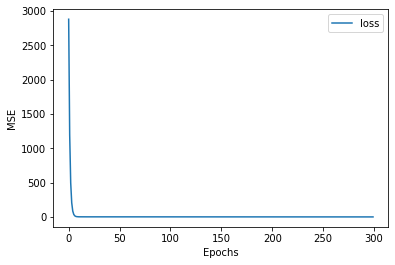

In [12]:
plt.plot(hist0.history['loss'])
plt.legend(['loss'])
plt.ylabel('MSE')
plt.xlabel('Epochs')
plt.show()

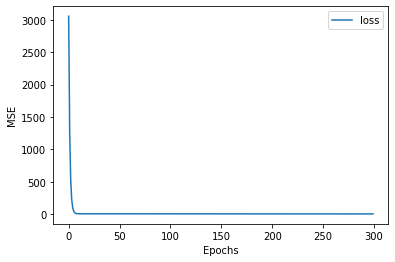

In [13]:
plt.plot(hist1.history['loss'])
plt.legend(['loss'])
plt.ylabel('MSE')
plt.xlabel('Epochs')
plt.show()

In [14]:
print("MSE TF-Model0: ", hist0.history['loss'][-1], "\nMSE TF-Model1: ", hist1.history['loss'][-1])

MSE TF-Model0:  1.7752044200897217 
MSE TF-Model1:  2.2500863075256348


### Ergebnis:
Uff, also immer schön Seed enforcen.

____

# 1. Kapitel: Simulation Einfach-Regression

Simulation eines Neuronalen Netzes welche eine einfach Regression versucht nachzubilden. Ziel ist hier zu sehen inwiefern die Methode über Finite Differences in der Lage ist die Degrees of Freedom in einem sehr einfachen Fall zu bestimmen. Darüberhinaus werden in den folgenden Schritten die Anzahl der Hidden Layer erweitert. Diese Werte werden allerdings nur eine Hidden Unit enthalten um weiterhin eine "einfache" Struktur zu enforcen.

Das Datenerstellende Modell sieht wie folgt aus:

$$
    y = \beta_0 + \beta_1 x_1 + N(0, 1),
$$

Die X-Werte werden aus einer stand. Normalverteilung gezogen. Das Model wird "nur" 100 Beobachtungen (n) haben. $\beta_0 = 1$ und $\beta_1 = 3$.

Generell nutzen wir erst einmal GD, indem wir SGD mit einer `batch_size = n` setzen.

### Libraries & Seeds

In [3]:
# System Libraries
import sys
import random
import copy
import time

# Costum Libraries
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import numpy as np
from numpy.linalg import inv
from tensorflow.python.ops.gen_array_ops import scatter_nd_eager_fallback
from tensorflow.python.ops.gen_logging_ops import timestamp
import matplotlib.pyplot as plt

random.seed(42)


### Daten Simulierendes Modell

In [4]:
n = 100
X = np.random.normal(loc=0.0, scale=1.0, size =n)
X = X.reshape(n, 1)
koef = np.array((3))
koef = koef.reshape(1,1)
noise = np.random.normal(loc=0.0, scale=1.0, size=n)
noise = noise.reshape(n, 1)
y = 1 + np.matmul(X, koef) + noise
y = pd.DataFrame(y)
X = pd.DataFrame(X)

### Differenz (h)

In [17]:
h = 1e-5

____

## 1.1 0-Hidden Layer/Hidden Units

In [5]:
opt = tf.keras.optimizers.Adam(
    learning_rate=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,
    name='Adam'
)

Grundlegenden Modell:

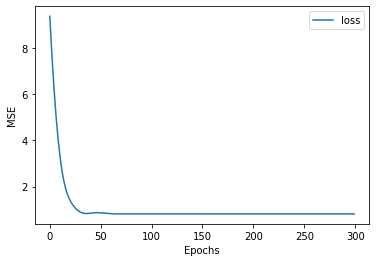

In [6]:
tf.random.set_seed(42)
model0 = tf.keras.Sequential()
model0.add(tf.keras.layers.Dense(1,  activation='linear', batch_input_shape=(None, 1)))
model0.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=opt)
hist = model0.fit(X, y, epochs = 300, batch_size=100, use_multiprocessing=True, verbose=0)
plt.plot(hist.history['loss'])
plt.legend(['loss'])
plt.ylabel('MSE')
plt.xlabel('Epochs')
plt.show()

### Ergebnisse

- $\hat{y}$ auslesen/berechnen.
- Ausgeben der "letzten" Loss.

In [7]:
yhat = model0.predict(X)
model0.get_weights()
print("Loss der letzten Epoche:", hist.history['loss'][-1], "\nweights:", model0.get_weights())

Loss der letzten Epoche: 0.8188770413398743 
weights: [array([[3.035874]], dtype=float32), array([0.98446786], dtype=float32)]


### Forward Differences

In [8]:
h = 1e-5
y_iter = []
gewichte_m = [ ]
fits = []
for i in range(len(X)):
  temp_y = copy.deepcopy(y)
  temp_y.loc[i] += h
  y_iter.append(temp_y)
  random.seed(42)
  tf.random.set_seed(42)
  model = tf.keras.Sequential();
  model.add(tf.keras.layers.Dense(1,  activation='linear', batch_input_shape=(None, 1)));
  model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=opt);
  hist = model.fit(X, temp_y, epochs = 300, batch_size=100, use_multiprocessing=True, verbose=0);
  coefs_m = np.vstack((model.get_weights()[0]))
  gewichte_m.append( coefs_m )
  temp_pred = model.predict(X)
  fits.append(temp_pred[i]);

fits_f = copy.deepcopy(np.array(fits))

### Backward Differences

In [9]:
y_iter = []
gewichte_m = [ ]
fits = []
for i in range(len(X)):
  temp_y = copy.deepcopy(y)
  temp_y.loc[i] -= h
  y_iter.append(temp_y)
  random.seed(42)
  tf.random.set_seed(42)
  model = tf.keras.Sequential();
  model.add(tf.keras.layers.Dense(1,  activation='linear', batch_input_shape=(None, 1)));
  model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=opt);
  hist = model.fit(X, temp_y, epochs = 300, batch_size=100, use_multiprocessing=True, verbose=0);
  coefs_m = np.vstack((model.get_weights()[0]))
  gewichte_m.append( coefs_m )
  temp_pred = model.predict(X)
  fits.append(temp_pred[i]);

fits_b = copy.deepcopy(np.array(fits))

### Analyse

In [10]:
# Grundlegendes Model:
model0.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 2         
                                                                 
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


In [11]:
print("Forward DFs: ", (np.sum((fits_f - yhat) / h)), "\nBackward DFs: ", (np.sum((yhat - fits_b) / h)), "\nCentered DFs: ", (np.sum((fits_f - fits_b) / (2 * h))))

Forward DFs:  4.184246 
Backward DFs:  -0.42319298 
Centered DFs:  1.8805265


### Ergebnisse

- Nun, zumindest eine der drei Methoden hat den zu erwartenden Wert von 2 erreicht.
- Aber zumindest alle drei um 2 herum ... zumindest etwas.
- Centered Diff ist wie zu erwarten am nähsten dran. Kein Wunder mit einem h von`python (1e-5)**2` 

____

## 1.2 Ein-Hidden-Layer/Unit


### Annahme
Idee hier, auch wenn wir jetzt ein HIdden Layer haben, haben wir nur eine Hidden Unit, wir haben trotzdem also pro Layer nur zwei Gewichte. 
Es sollte also so kommen, dass auch wenn wit jetzt 4 trainierbare Parameter haben, wir trotzdem nur einen DF von 2 haben sollten.


### Grundlegendes Modell:

In [25]:
random.seed(42)
tf.random.set_seed(42)

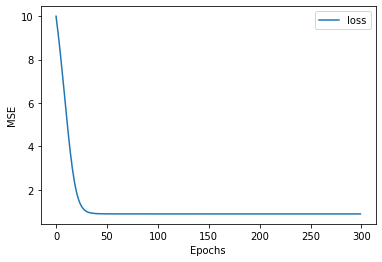

In [26]:
model0 = tf.keras.Sequential()
model0.add(tf.keras.layers.Dense(1,  activation='linear', batch_input_shape=(None, 1)))
model0.add(tf.keras.layers.Dense(1,  activation='linear'))
model0.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=opt)
hist = model0.fit(X, y, epochs = 300, batch_size=100, use_multiprocessing=True, verbose=0)
plt.plot(hist.history['loss'])
plt.legend(['loss'])
plt.ylabel('MSE')
plt.xlabel('Epochs')
plt.show()

In [27]:
yhat = model0.predict(X)
print("Loss der letzten Epoche:", hist.history['loss'][-1])

Loss der letzten Epoche: 0.8810569047927856


### Forward Differences

In [28]:
y_iter = []
gewichte_m = [ ]
fits = []
for i in range(len(X)):
  temp_y = copy.deepcopy(y)
  temp_y.loc[i] += h
  y_iter.append(temp_y)
  random.seed(42)
  tf.random.set_seed(42)
  model = tf.keras.Sequential();
  model.add(tf.keras.layers.Dense(1,  activation='linear', batch_input_shape=(None, 1)));
  model.add(tf.keras.layers.Dense(1,  activation='linear'));
  model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=opt);
  hist = model.fit(X, temp_y, epochs = 300, batch_size=100, use_multiprocessing=True, verbose=0);
  coefs_m = np.vstack((model.get_weights()[0]))
  gewichte_m.append( coefs_m )
  temp_pred = model.predict(X)
  fits.append(temp_pred[i]);

fits_f = copy.deepcopy(np.array(fits))

### Backward Differences

In [29]:
y_iter = []
gewichte_m = [ ]
fits = []
for i in range(len(X)):
  temp_y = copy.deepcopy(y)
  temp_y.loc[i] -= h
  y_iter.append(temp_y)
  random.seed(42)
  tf.random.set_seed(42)
  model = tf.keras.Sequential();
  model.add(tf.keras.layers.Dense(1,  activation='linear', batch_input_shape=(None, 1)));
  model.add(tf.keras.layers.Dense(1,  activation='linear'));
  model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=opt);
  hist = model.fit(X, temp_y, epochs = 300, batch_size=100, use_multiprocessing=True, verbose=0);
  coefs_m = np.vstack((model.get_weights()[0]))
  gewichte_m.append( coefs_m )
  temp_pred = model.predict(X)
  fits.append(temp_pred[i]);

fits_b = copy.deepcopy(np.array(fits))

### Analyse

In [30]:
# Grundlegendes Model:
model0.summary()

Model: "sequential_203"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_203 (Dense)           (None, 1)                 2         
                                                                 
 dense_204 (Dense)           (None, 1)                 2         
                                                                 
Total params: 4
Trainable params: 4
Non-trainable params: 0
_________________________________________________________________


In [31]:
print("Forward DFs: ", (np.sum((fits_f - yhat) / h)), "\nBackward DFs: ", (np.sum((yhat - fits_b) / h)), "\nCentered DFs: ", (np.sum((fits_f - fits_b) / (2 * h))))

Forward DFs:  1.5571713 
Backward DFs:  1.9297004 
Centered DFs:  1.7434359


### Ergebnisse

- Alle drei um 2 herum.
- Bestätigt meine Erwartung an diese Simulation, dass wir eigentlich nur einen DF von 2 haben, da wir nur eine Hidden Unit haben. 
- Lustigerweise, ist Centered nicht am nähesten an 2. 
  - Wird der DF kleiner?
  - Oder ist es einfach ein Problem mit der Methode?

_____

## 1.3 Zwei-Hidden-Layer je eine Hidden Unit


### Annahme
Erweiterung des Kapitel 1.2.
Idee hier, auch wenn wir jetzt zwei Hidden Layer haben, haben wir nur eine Hidden Unit, wir haben trotzdem also pro Layer nur zwei Gewichte. 
Es sollte also so kommen, dass auch wenn wit jetzt 6 trainierbare Parameter haben, wir trotzdem nur einen DF von 2 haben sollten.



### Grundlegendes Modell:

In [32]:
random.seed(42)
tf.random.set_seed(42)

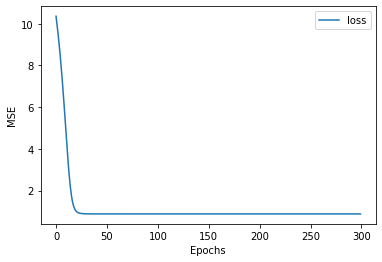

In [33]:
model0 = tf.keras.Sequential()
model0.add(tf.keras.layers.Dense(1,  activation='linear', batch_input_shape=(None, 1)))
model0.add(tf.keras.layers.Dense(1,  activation='linear'))
model0.add(tf.keras.layers.Dense(1,  activation='linear'))
model0.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=opt)
hist = model0.fit(X, y, epochs = 300, batch_size=100, use_multiprocessing=True, verbose=0)
plt.plot(hist.history['loss'])
plt.legend(['loss'])
plt.ylabel('MSE')
plt.xlabel('Epochs')
plt.show()

In [34]:
yhat = model0.predict(X)
print("Loss der letzten Epoche:", hist.history['loss'][-1])

Loss der letzten Epoche: 0.8810569643974304


### Forward Differences

In [35]:
y_iter = []
gewichte_m = [ ]
fits = []
for i in range(len(X)):
  temp_y = copy.deepcopy(y)
  temp_y.loc[i] += h
  y_iter.append(temp_y)
  random.seed(42)
  tf.random.set_seed(42)
  model = tf.keras.Sequential();
  model.add(tf.keras.layers.Dense(1,  activation='linear', batch_input_shape=(None, 1)));
  model.add(tf.keras.layers.Dense(1,  activation='linear'));
  model.add(tf.keras.layers.Dense(1,  activation='linear'));
  model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=opt);
  hist = model.fit(X, temp_y, epochs = 300, batch_size=100, use_multiprocessing=True, verbose=0);
  coefs_m = np.vstack((model.get_weights()[0]))
  gewichte_m.append( coefs_m )
  temp_pred = model.predict(X)
  fits.append(temp_pred[i]);

fits_f = copy.deepcopy(np.array(fits))

### Backward Differences

In [36]:
y_iter = []
gewichte_m = [ ]
fits = []
for i in range(len(X)):
  temp_y = copy.deepcopy(y)
  temp_y.loc[i] -= h
  y_iter.append(temp_y)
  random.seed(42)
  tf.random.set_seed(42)
  model = tf.keras.Sequential();
  model.add(tf.keras.layers.Dense(1,  activation='linear', batch_input_shape=(None, 1)));
  model.add(tf.keras.layers.Dense(1,  activation='linear'));
  model.add(tf.keras.layers.Dense(1,  activation='linear'));
  model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=opt);
  hist = model.fit(X, temp_y, epochs = 300, batch_size=100, use_multiprocessing=True, verbose=0);
  coefs_m = np.vstack((model.get_weights()[0]))
  gewichte_m.append( coefs_m )
  temp_pred = model.predict(X)
  fits.append(temp_pred[i]);

fits_b = copy.deepcopy(np.array(fits))

### Analyse

In [37]:
# Grundlegendes Model:
model0.summary()

Model: "sequential_404"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_605 (Dense)           (None, 1)                 2         
                                                                 
 dense_606 (Dense)           (None, 1)                 2         
                                                                 
 dense_607 (Dense)           (None, 1)                 2         
                                                                 
Total params: 6
Trainable params: 6
Non-trainable params: 0
_________________________________________________________________


In [38]:
print("Forward DFs: ", (np.sum((fits_f - yhat) / h)), "\nBackward DFs: ", (np.sum((yhat - fits_b) / h)), "\nCentered DFs: ", (np.sum((fits_f - fits_b) / (2 * h))))

Forward DFs:  2.0876527 
Backward DFs:  2.1532178 
Centered DFs:  2.1204352


### Ergebnisse

- Wie bei den vorigen beiden Kapiteln, auch hier um/nahe 2.
- Ergibt Sinn, da wir zwar Hidden Layer/Hidden Units haben, aber im Endeffect die Anzahl der Gewichte im Layer (2) konstant über alle Layer bleibt, sodass eine Anpassung der Prediction eigentlich nur im letzten Layer wirklich stattfindet.

____

## Ergebnis des Kapitels:

- Die Methode kommt an die unterstellte Anzahl (k = 2) nahe herang.
- Es gibt Unterschiede zwischen dem Ergebnis und der wahren Zahl, aber diese sind meiner Meinung nach der numerischen Eigenheiten der Methode und dem Einfluss des Noises auf den Daten geschuldet.
- Im nächsten Schritt anschauen wie sich die Ergebnisse verändern, wenn die Hiddenlayer mehr als eine Hidden Unit beihalten.
  - Mehr in späteren Kapiteln.


____

# 2. Kapitel: Regressionsdaten (k = 3 + 1)

Jetzt simulieren von Daten die mehr Parameter beinhalten. Der Datenerzeugende Prozess wird mehr als einen Slope Paramter beinhalten.
Hierfür werden wir wie im Kapitel 1 erst Modelle nur mit einer Hidden Unit simuliert, aber daraufaufbauend auch Modelle mit mehreren Hidden Units.

Ziel ist hierbei zu schauen, ob es spezifische Layer gibt die die Anzahl an DFs beeinflusst. (Und wann es Probleme mit der Berechnung gibt).

Das Datenerzeugende Modell sieht so aus:

$$
    y = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \beta_3 x_3 + \beta_4 x_4 + N(0, 1),
$$

Die X-Werte werden aus einer stand. Normalverteilunge gezogen. Das Model wird "nur" 100 Beobachtungen (n) haben. $\beta_0 = 1$, $\beta_1 = 3$, $\beta_2 = 5$ und , $\beta_3 = 7$.

Generell nutzen wir erst einmal GD, indem wir SGD mit einer `batch_size = n` setzen.

### Libraries & Seeds

In [39]:
# System Libraries
import sys
import random
import copy
import time

# Costum Libraries
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import numpy as np
from numpy.linalg import inv
from tensorflow.python.ops.gen_array_ops import scatter_nd_eager_fallback
from tensorflow.python.ops.gen_logging_ops import timestamp
import matplotlib.pyplot as plt

random.seed(42)

### Daten simulierder Prozess

In [40]:
n = 100
k = 3 # Parameters - Intercept
X = np.random.normal(loc=0.0, scale=1.0, size =(n*k))
X = X.reshape(n, k)
koef = np.array((3, 5, 7))
koef = koef.reshape(k,1)
noise = np.random.normal(loc=0.0, scale=1, size=n)
noise = noise.reshape(n, 1)
y = 1 + np.matmul(X, koef) + noise
y = pd.DataFrame(y)
X = pd.DataFrame(X)

_____

## 2.1. "Regression" ohne Hidden Layer

In [41]:
tf.random.set_seed(42)
opt = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.0, nesterov=False, name='SGD')

### Grundlegendes Modell

$$
    \hat{y} = \hat{\beta_0} + \hat{\beta_1} x_1 + \hat{\beta_2} x_2 + \hat{\beta_3} x_3
$$

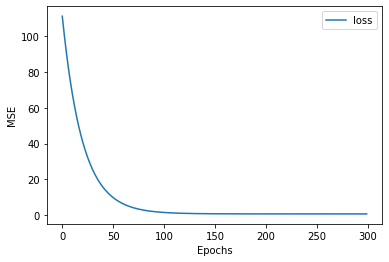

In [42]:
model0 = tf.keras.Sequential()
model0.add(tf.keras.layers.Dense(1,  activation='linear', batch_input_shape=(None, 3)))
model0.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=opt)
hist = model0.fit(X, y, epochs = 300, batch_size=100, use_multiprocessing=True, verbose=0)
plt.plot(hist.history['loss'])
plt.legend(['loss'])
plt.ylabel('MSE')
plt.xlabel('Epochs')
plt.show()

### Ergebnisse

In [43]:
yhat = model0.predict(X)
print("Loss der letzten Epoche:", hist.history['loss'][-1], "\nweights:", model0.get_weights())

Loss der letzten Epoche: 0.7825955152511597 
weights: [array([[3.079707 ],
       [5.188942 ],
       [6.8999214]], dtype=float32), array([0.8886462], dtype=float32)]


### Forward Differences

In [44]:
y_iter = []
gewichte_m = [ ]
fits = []
for i in range(len(X)):
  temp_y = copy.deepcopy(y)
  temp_y.loc[i] += h
  y_iter.append(temp_y)
  random.seed(42)
  tf.random.set_seed(42)
  model = tf.keras.Sequential();
  model.add(tf.keras.layers.Dense(1,  activation='linear', batch_input_shape=(None, 3)));
  model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=opt);
  hist = model.fit(X, temp_y, epochs = 300, batch_size=100, use_multiprocessing=True, verbose=0);
  coefs_m = np.vstack((model.get_weights()[0]))
  gewichte_m.append( coefs_m )
  temp_pred = model.predict(X)
  fits.append(temp_pred[i]);

fits_f = copy.deepcopy(np.array(fits))

### Backward Differences

In [45]:
y_iter = []
gewichte_m = [ ]
fits = []
for i in range(len(X)):
  temp_y = copy.deepcopy(y)
  temp_y.loc[i] -= h
  y_iter.append(temp_y)
  random.seed(42)
  tf.random.set_seed(42)
  model = tf.keras.Sequential();
  model.add(tf.keras.layers.Dense(1,  activation='linear', batch_input_shape=(None, 3)));
  model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=opt);
  hist = model.fit(X, temp_y, epochs = 300, batch_size=100, use_multiprocessing=True, verbose=0);
  coefs_m = np.vstack((model.get_weights()[0]))
  gewichte_m.append( coefs_m )
  temp_pred = model.predict(X)
  fits.append(temp_pred[i]);

fits_b = copy.deepcopy(np.array(fits))

### Analyse

In [46]:
# Grundlegendes Model:
model0.summary()

Model: "sequential_605"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1208 (Dense)          (None, 1)                 4         
                                                                 
Total params: 4
Trainable params: 4
Non-trainable params: 0
_________________________________________________________________


In [47]:
print("Forward DFs: ", (np.sum((fits_f - yhat) / h)), "\nBackward DFs: ", (np.sum((yhat - fits_b) / h)), "\nCentered DFs: ", (np.sum((fits_f - fits_b) / (2 * h))))

Forward DFs:  1.7881393 
Backward DFs:  5.5611134 
Centered DFs:  3.6746264


### Ergebnisse:

- Uff, Forward unterschätzt extrem.
  - Backward überschätzt.
  - Centered kommt schon ins Gefilde um 4.
- Jetzt stellt sich die Frage wie viel davon hat mit der Methode, dem Noise auf den Daten und numerischen Prozessen zu tun?

____

## 2.2. Regression mit drei Hidden Layern

### 2.2.1 Alles eine Unit

In [48]:
tf.random.set_seed(42)
opt = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.0, nesterov=False, name='SGD')

#### Grundlegendes Modell


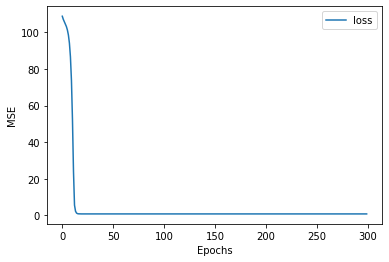

In [49]:
model0 = tf.keras.Sequential()
model0.add(tf.keras.layers.Dense(1,  activation='linear', batch_input_shape=(None, 3)))
model0.add(tf.keras.layers.Dense(1,  activation='linear'))
model0.add(tf.keras.layers.Dense(1,  activation='linear'));
model0.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=opt)
hist = model0.fit(X, y, epochs = 300, batch_size=100, use_multiprocessing=True, verbose=0)
plt.plot(hist.history['loss'])
plt.legend(['loss'])
plt.ylabel('MSE')
plt.xlabel('Epochs')
plt.show()

#### Ergebnisse

In [50]:
yhat = model0.predict(X)
print("Loss der letzten Epoche:", hist.history['loss'][-1])

Loss der letzten Epoche: 0.7825071811676025


#### Forward Differences

In [51]:
y_iter = []
gewichte_m = [ ]
fits = []
for i in range(len(X)):
  temp_y = copy.deepcopy(y)
  temp_y.loc[i] += h
  y_iter.append(temp_y)
  random.seed(42)
  tf.random.set_seed(42)
  model = tf.keras.Sequential();
  model.add(tf.keras.layers.Dense(1,  activation='linear', batch_input_shape=(None, 3)));
  model.add(tf.keras.layers.Dense(1,  activation='linear'));
  model.add(tf.keras.layers.Dense(1,  activation='linear'));
  model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=opt);
  hist = model.fit(X, temp_y, epochs = 300, batch_size=100, use_multiprocessing=True, verbose=0);
  coefs_m = np.vstack((model.get_weights()[0]))
  gewichte_m.append( coefs_m )
  temp_pred = model.predict(X)
  fits.append(temp_pred[i]);

fits_f = copy.deepcopy(np.array(fits))

#### Backward Differences

In [52]:
y_iter = []
gewichte_m = [ ]
fits = []
for i in range(len(X)):
  temp_y = copy.deepcopy(y)
  temp_y.loc[i] -= h
  y_iter.append(temp_y)
  random.seed(42)
  tf.random.set_seed(42)
  model = tf.keras.Sequential();
  model.add(tf.keras.layers.Dense(1,  activation='linear', batch_input_shape=(None, 3)));
  model.add(tf.keras.layers.Dense(1,  activation='linear'));
  model.add(tf.keras.layers.Dense(1,  activation='linear'));
  model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=opt);
  hist = model.fit(X, temp_y, epochs = 300, batch_size=100, use_multiprocessing=True, verbose=0);
  coefs_m = np.vstack((model.get_weights()[0]))
  gewichte_m.append( coefs_m )
  temp_pred = model.predict(X)
  fits.append(temp_pred[i]);

fits_b = copy.deepcopy(np.array(fits))

#### Analyse

In [53]:
# Grundlegendes Model:
model0.summary()

Model: "sequential_806"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1409 (Dense)          (None, 1)                 4         
                                                                 
 dense_1410 (Dense)          (None, 1)                 2         
                                                                 
 dense_1411 (Dense)          (None, 1)                 2         
                                                                 
Total params: 8
Trainable params: 8
Non-trainable params: 0
_________________________________________________________________


In [54]:
print("Forward DFs: ", (np.sum((fits_f - yhat) / h)), "\nBackward DFs: ", (np.sum((yhat - fits_b) / h)), "\nCentered DFs: ", (np.sum((fits_f - fits_b) / (2 * h))))

Forward DFs:  4.6372414 
Backward DFs:  3.5837293 
Centered DFs:  4.110485


#### Ergebnisse:

- Okay wir werden besser! 
  - interessanterweise wird das Ergebnis "besser" um so mehr Layer wir haben!
  - Macht es Sinn? Und wieso sollte die Methode bei einfachen Modellen so daneben liegen? 
____

### 2.2.2. Hiden Units 10-1-1-1

In [55]:
tf.random.set_seed(42)
opt = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.0, nesterov=False, name='SGD')

#### Grundlegendes Modell

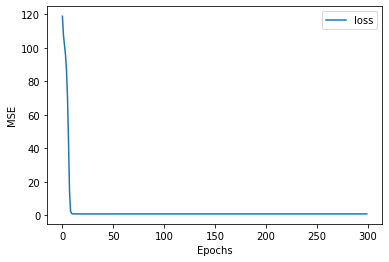

In [56]:
model0 = tf.keras.Sequential()
model0.add(tf.keras.layers.Dense(10,  activation='linear', batch_input_shape=(None, 3)))
model0.add(tf.keras.layers.Dense(1,  activation='linear'))
model0.add(tf.keras.layers.Dense(1,  activation='linear'));
model0.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=opt)
hist = model0.fit(X, y, epochs = 300, batch_size=100, use_multiprocessing=True, verbose=0)
plt.plot(hist.history['loss'])
plt.legend(['loss'])
plt.ylabel('MSE')
plt.xlabel('Epochs')
plt.show()

#### Ergebnis

In [57]:
yhat = model0.predict(X)
print("Loss der letzten Epoche:", hist.history['loss'][-1])

Loss der letzten Epoche: 0.7825071811676025


#### Forward Differences

In [58]:
y_iter = []
gewichte_m = [ ]
fits = []
for i in range(len(X)):
  temp_y = copy.deepcopy(y)
  temp_y.loc[i] += h
  y_iter.append(temp_y)
  random.seed(42)
  tf.random.set_seed(42)
  model = tf.keras.Sequential();
  model.add(tf.keras.layers.Dense(10,  activation='linear', batch_input_shape=(None, 3)));
  model.add(tf.keras.layers.Dense(1,  activation='linear'));
  model.add(tf.keras.layers.Dense(1,  activation='linear'));
  model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=opt);
  hist = model.fit(X, temp_y, epochs = 300, batch_size=100, use_multiprocessing=True, verbose=0);
  coefs_m = np.vstack((model.get_weights()[0]))
  gewichte_m.append( coefs_m )
  temp_pred = model.predict(X)
  fits.append(temp_pred[i]);

fits_f = copy.deepcopy(np.array(fits))

#### Backward Differences

In [59]:
y_iter = []
gewichte_m = [ ]
fits = []
for i in range(len(X)):
  temp_y = copy.deepcopy(y)
  temp_y.loc[i] -= h
  y_iter.append(temp_y)
  random.seed(42)
  tf.random.set_seed(42)
  model = tf.keras.Sequential();
  model.add(tf.keras.layers.Dense(10,  activation='linear', batch_input_shape=(None, 3)));
  model.add(tf.keras.layers.Dense(1,  activation='linear'));
  model.add(tf.keras.layers.Dense(1,  activation='linear'));
  model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=opt);
  hist = model.fit(X, temp_y, epochs = 300, batch_size=100, use_multiprocessing=True, verbose=0);
  coefs_m = np.vstack((model.get_weights()[0]))
  gewichte_m.append( coefs_m )
  temp_pred = model.predict(X)
  fits.append(temp_pred[i]);

fits_b = copy.deepcopy(np.array(fits))

#### Analyse

In [60]:
# Grundlegendes Model:
model0.summary()

Model: "sequential_1007"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2012 (Dense)          (None, 10)                40        
                                                                 
 dense_2013 (Dense)          (None, 1)                 11        
                                                                 
 dense_2014 (Dense)          (None, 1)                 2         
                                                                 
Total params: 53
Trainable params: 53
Non-trainable params: 0
_________________________________________________________________


In [61]:
print("Forward DFs: ", (np.sum((fits_f - yhat) / h)), "\nBackward DFs: ", (np.sum((yhat - fits_b) / h)), "\nCentered DFs: ", (np.sum((fits_f - fits_b) / (2 * h))))

Forward DFs:  5.7242813 
Backward DFs:  2.5749207 
Centered DFs:  4.149601


#### Ergebnisse

- Centered wieder nah an 4 dran. die anderen Werte liegen weit auseinander.
- !Notiz! Auch hier, egal wie viele Layer/Units wir unterstellen, die DFs der Centered (und auch der anderen im gewissen Maße) streben gegen die Anzahl der Inputs ($X$) wir enden also quasi in der Annahme der Linearen Modelle, dass DF = k + 1.

____


### 2.2.3. Hiden Units 1-10-1

In [62]:
tf.random.set_seed(42)
opt = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.0, nesterov=False, name='SGD')

#### Grundlegendes Modell

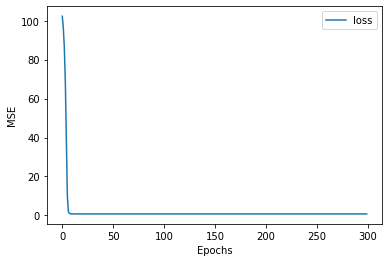

In [63]:
model0 = tf.keras.Sequential()
model0.add(tf.keras.layers.Dense(1,  activation='linear', batch_input_shape=(None, 3)))
model0.add(tf.keras.layers.Dense(10,  activation='linear'))
model0.add(tf.keras.layers.Dense(1,  activation='linear'));
model0.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=opt)
hist = model0.fit(X, y, epochs = 300, batch_size=100, use_multiprocessing=True, verbose=0)
plt.plot(hist.history['loss'])
plt.legend(['loss'])
plt.ylabel('MSE')
plt.xlabel('Epochs')
plt.show()

#### Ergebnisse

In [64]:
yhat = model0.predict(X)
print("Loss der letzten Epoche:", hist.history['loss'][-1])

Loss der letzten Epoche: 0.7825071811676025


#### Forward Differences

In [65]:
y_iter = []
gewichte_m = [ ]
fits = []
for i in range(len(X)):
  temp_y = copy.deepcopy(y)
  temp_y.loc[i] += h
  y_iter.append(temp_y)
  random.seed(42)
  tf.random.set_seed(42)
  model = tf.keras.Sequential();
  model.add(tf.keras.layers.Dense(10,  activation='linear', batch_input_shape=(None, 3)));
  model.add(tf.keras.layers.Dense(1,  activation='linear'));
  model.add(tf.keras.layers.Dense(1,  activation='linear'));
  model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=opt);
  hist = model.fit(X, temp_y, epochs = 300, batch_size=100, use_multiprocessing=True, verbose=0);
  coefs_m = np.vstack((model.get_weights()[0]))
  gewichte_m.append( coefs_m )
  temp_pred = model.predict(X)
  fits.append(temp_pred[i]);

fits_f = copy.deepcopy(np.array(fits))

#### Backward Differences

In [66]:
y_iter = []
gewichte_m = [ ]
fits = []
for i in range(len(X)):
  temp_y = copy.deepcopy(y)
  temp_y.loc[i] -= h
  y_iter.append(temp_y)
  random.seed(42)
  tf.random.set_seed(42)
  model = tf.keras.Sequential();
  model.add(tf.keras.layers.Dense(1,  activation='linear', batch_input_shape=(None, 3)));
  model.add(tf.keras.layers.Dense(10,  activation='linear'));
  model.add(tf.keras.layers.Dense(1,  activation='linear'));
  model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=opt);
  hist = model.fit(X, temp_y, epochs = 300, batch_size=100, use_multiprocessing=True, verbose=0);
  coefs_m = np.vstack((model.get_weights()[0]))
  gewichte_m.append( coefs_m )
  temp_pred = model.predict(X)
  fits.append(temp_pred[i]);

fits_b = copy.deepcopy(np.array(fits))

#### Analyse

In [67]:
# Grundlegendes Model:
model0.summary()

Model: "sequential_1208"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2615 (Dense)          (None, 1)                 4         
                                                                 
 dense_2616 (Dense)          (None, 10)                20        
                                                                 
 dense_2617 (Dense)          (None, 1)                 11        
                                                                 
Total params: 35
Trainable params: 35
Non-trainable params: 0
_________________________________________________________________


In [68]:
print("Forward DFs: ", (np.sum((fits_f - yhat) / h)), "\nBackward DFs: ", (np.sum((yhat - fits_b) / h)), "\nCentered DFs: ", (np.sum((fits_f - fits_b) / (2 * h))))

Forward DFs:  5.1781535 
Backward DFs:  2.7187169 
Centered DFs:  3.9484353


#### Ergebnisse

- Genau die selben Beobachtungen wie in 2.2.2.

_____

### 2.2.3 Hidden Units 10-10-1

In [69]:
tf.random.set_seed(42)
opt = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.0, nesterov=False, name='SGD')

#### Grundlegendes Modell

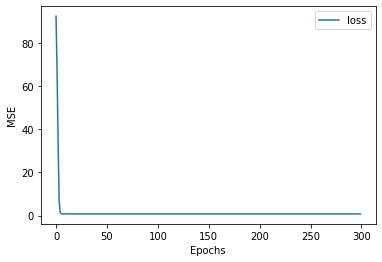

In [70]:
model0 = tf.keras.Sequential()
model0.add(tf.keras.layers.Dense(10,  activation='linear', batch_input_shape=(None, 3)))
model0.add(tf.keras.layers.Dense(10,  activation='linear'))
model0.add(tf.keras.layers.Dense(1,  activation='linear'));
model0.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=opt)
hist = model0.fit(X, y, epochs = 300, batch_size=100, use_multiprocessing=True, verbose=0)
plt.plot(hist.history['loss'])
plt.legend(['loss'])
plt.ylabel('MSE')
plt.xlabel('Epochs')
plt.show()

#### Ergebnis

In [71]:
yhat = model0.predict(X)
print("Loss der letzten Epoche:", hist.history['loss'][-1])

Loss der letzten Epoche: 0.7825067043304443


#### Forward Diff

In [72]:
gewichte_m = [ ]
y_iter = []
gewichte_m = [ ]
fits = []
for i in range(len(X)):
  temp_y = copy.deepcopy(y)
  temp_y.loc[i] += h
  y_iter.append(temp_y)
  random.seed(42)
  tf.random.set_seed(42)
  model = tf.keras.Sequential();
  model.add(tf.keras.layers.Dense(10,  activation='linear', batch_input_shape=(None, 3)));
  model.add(tf.keras.layers.Dense(10,  activation='linear'));
  model.add(tf.keras.layers.Dense(1,  activation='linear'));
  model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=opt);
  hist = model.fit(X, temp_y, epochs = 300, batch_size=100, use_multiprocessing=True, verbose=0);
  coefs_m = np.vstack((model.get_weights()[0]))
  gewichte_m.append( coefs_m )
  temp_pred = model.predict(X)
  fits.append(temp_pred[i]);

fits_f = copy.deepcopy(np.array(fits))

#### Backward Diff

In [73]:
gewichte_m = [ ]
y_iter = []
gewichte_m = [ ]
fits = []
for i in range(len(X)):
  temp_y = copy.deepcopy(y)
  temp_y.loc[i] -= h
  y_iter.append(temp_y)
  random.seed(42)
  tf.random.set_seed(42)
  model = tf.keras.Sequential();
  model.add(tf.keras.layers.Dense(10,  activation='linear', batch_input_shape=(None, 3)));
  model.add(tf.keras.layers.Dense(10,  activation='linear'));
  model.add(tf.keras.layers.Dense(1,  activation='linear'));
  model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=opt);
  hist = model.fit(X, temp_y, epochs = 300, batch_size=100, use_multiprocessing=True, verbose=0);
  coefs_m = np.vstack((model.get_weights()[0]))
  gewichte_m.append( coefs_m )
  temp_pred = model.predict(X)
  fits.append(temp_pred[i]);

fits_b = copy.deepcopy(np.array(fits))

#### Analyse

In [74]:
# Grundlegendes Model:
model0.summary()

Model: "sequential_1409"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3218 (Dense)          (None, 10)                40        
                                                                 
 dense_3219 (Dense)          (None, 10)                110       
                                                                 
 dense_3220 (Dense)          (None, 1)                 11        
                                                                 
Total params: 161
Trainable params: 161
Non-trainable params: 0
_________________________________________________________________


In [75]:
print("Forward DFs: ", (np.sum((fits_f - yhat) / h)), "\nBackward DFs: ", (np.sum((yhat - fits_b) / h)), "\nCentered DFs: ", (np.sum((fits_f - fits_b) / (2 * h))))

Forward DFs:  4.810095 
Backward DFs:  4.245341 
Centered DFs:  4.5277176


#### Ergebnisse

- Zum ersten Mal konstant über dem Wert von 4, bei allen Differenzen.
- Ergibt Sinn, wir haben ja mehr trainierbare Parameter als 4.
  - Auch hier wieder interessant, dass die berechneten DF Werte nahe an der Anzahl der Inputs ist.
____

# 3. Kapitel Komplexe Modelle

In [76]:
# System Libraries
import sys
import random
import copy
import time

# Costum Libraries
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import numpy as np
from numpy.linalg import inv
from tensorflow.python.ops.gen_array_ops import scatter_nd_eager_fallback
from tensorflow.python.ops.gen_logging_ops import timestamp
import matplotlib.pyplot as plt

random.seed(42)

### Datensimulierender Prozess

In [77]:
n = 300
k = 6 # Parameters - Intercept
X = np.random.normal(loc=0.0, scale=1.0, size =(n*k))
X = X.reshape(n, k)
koef = np.array((2, 3, 4, 5, 6, 7))
koef = koef.reshape(k,1)
noise = np.random.normal(loc=0.0, scale=1, size=n)
noise = noise.reshape(n, 1)
y = 1 + np.matmul(X, koef) + noise
y = pd.DataFrame(y)
X = pd.DataFrame(X)

_____

## 3.1. Regressions Model

In [85]:
tf.random.set_seed(42)
opt = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.0, nesterov=False, name='SGD')

### Grundlegendes Model

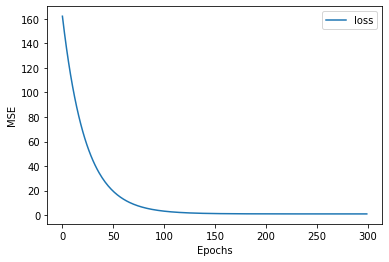

In [86]:
model0 = tf.keras.Sequential()
model0.add(tf.keras.layers.Dense(1,  activation='linear', batch_input_shape=(None, 6)))
model0.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=opt)
hist = model0.fit(X, y, epochs = 300, batch_size=300, use_multiprocessing=True, verbose=0)
plt.plot(hist.history['loss'])
plt.legend(['loss'])
plt.ylabel('MSE')
plt.xlabel('Epochs')
plt.show()

### Ergebnisse

In [87]:
yhat = model0.predict(X)
print("Loss der letzten Epoche:", hist.history['loss'][-1])

Loss der letzten Epoche: 0.9170880913734436


### Forward Differences

In [88]:
y_iter = []
gewichte_m = [ ]
fits = []
for i in range(len(X)):
  temp_y = copy.deepcopy(y)
  temp_y.loc[i] += h
  y_iter.append(temp_y)
  random.seed(42)
  tf.random.set_seed(42)
  model = tf.keras.Sequential();
  model.add(tf.keras.layers.Dense(1,  activation='linear', batch_input_shape=(None, 6)));
  model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=opt);
  hist = model.fit(X, temp_y, epochs = 300, batch_size=300, use_multiprocessing=True, verbose=0);
  coefs_m = np.vstack((model.get_weights()[0]))
  gewichte_m.append( coefs_m )
  temp_pred = model.predict(X)
  fits.append(temp_pred[i]);

fits_f = copy.deepcopy(np.array(fits))

### Backward Differences

In [89]:
y_iter = []
gewichte_m = [ ]
fits = []
for i in range(len(X)):
  temp_y = copy.deepcopy(y)
  temp_y.loc[i] -= h
  y_iter.append(temp_y)
  random.seed(42)
  tf.random.set_seed(42)
  model = tf.keras.Sequential();
  model.add(tf.keras.layers.Dense(1,  activation='linear', batch_input_shape=(None, 6)));
  model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=opt);
  hist = model.fit(X, temp_y, epochs = 300, batch_size=300, use_multiprocessing=True, verbose=0);
  coefs_m = np.vstack((model.get_weights()[0]))
  gewichte_m.append( coefs_m )
  temp_pred = model.predict(X)
  fits.append(temp_pred[i]);

fits_b = copy.deepcopy(np.array(fits))

### Analyse

In [90]:
# Grundlegendes Model:
model0.summary()

Model: "sequential_2211"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4422 (Dense)          (None, 1)                 7         
                                                                 
Total params: 7
Trainable params: 7
Non-trainable params: 0
_________________________________________________________________


In [91]:
print("Forward DFs: ", (np.sum((fits_f - yhat) / h)), "\nBackward DFs: ", (np.sum((yhat - fits_b) / h)), "\nCentered DFs: ", (np.sum((fits_f - fits_b) / (2 * h))))

Forward DFs:  10.979176 
Backward DFs:  6.7710876 
Centered DFs:  8.875132


#### Ergebnisse

- UND JETZT BEGINNT DER QUATSCH .... MAN.
- Wie kann bei diesem Modell (ohne hidden Units/layer), also per Definition ein Lineares Modell ein Wert für DF so beschissen sein?
  - Backward ist noch am nahsten dran. 
  - Wie kann es sein, dass die Centered Methode mit einer so relativ kleinen Fehlerfunktion so stark daneben liegen? Wäre mal ne Frage an Benji.
______

## Jetzt auch in groß.

In [97]:
tf.random.set_seed(42)
opt = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.0, nesterov=False, name='SGD')

#### Grundlegendes Modell

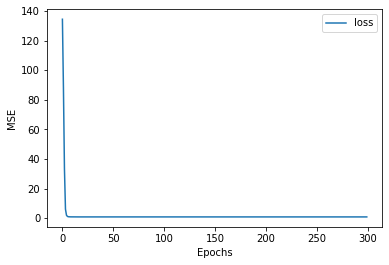

In [98]:
model0 = tf.keras.Sequential()
model0.add(tf.keras.layers.Dense(20,  activation='linear', batch_input_shape=(None, 6)))
model0.add(tf.keras.layers.Dense(20,  activation='linear'))
model0.add(tf.keras.layers.Dense(1,  activation='linear'))
model0.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=opt)
hist = model0.fit(X, y, epochs = 300, batch_size=300, use_multiprocessing=True, verbose=0)
plt.plot(hist.history['loss'])
plt.legend(['loss'])
plt.ylabel('MSE')
plt.xlabel('Epochs')
plt.show()

#### Ergebnisse

In [99]:
yhat = model0.predict(X)
print("Loss der letzten Epoche:", hist.history['loss'][-1])

Loss der letzten Epoche: 0.916271984577179


#### Forward Diffs

In [100]:
y_iter = []
gewichte_m = [ ]
fits = []
for i in range(len(X)):
  temp_y = copy.deepcopy(y)
  temp_y.loc[i] += h
  y_iter.append(temp_y)
  random.seed(42)
  tf.random.set_seed(42)
  model = tf.keras.Sequential();
  model.add(tf.keras.layers.Dense(20,  activation='linear', batch_input_shape=(None, 6)));
  model.add(tf.keras.layers.Dense(20,  activation='linear'));
  model.add(tf.keras.layers.Dense(1,  activation='linear'));
  model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=opt);
  hist = model.fit(X, temp_y, epochs = 300, batch_size=300, use_multiprocessing=True, verbose=0);
  coefs_m = np.vstack((model.get_weights()[0]))
  gewichte_m.append( coefs_m )
  temp_pred = model.predict(X)
  fits.append(temp_pred[i]);

fits_f = copy.deepcopy(np.array(fits))

#### Backward Diffs

In [101]:
y_iter = []
gewichte_m = [ ]
fits = []
for i in range(len(X)):
  temp_y = copy.deepcopy(y)
  temp_y.loc[i] -= h
  y_iter.append(temp_y)
  random.seed(42)
  tf.random.set_seed(42)
  model = tf.keras.Sequential();
  model.add(tf.keras.layers.Dense(20,  activation='linear', batch_input_shape=(None, 6)));
  model.add(tf.keras.layers.Dense(20,  activation='linear'));
  model.add(tf.keras.layers.Dense(1,  activation='linear'));
  model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=opt);
  hist = model.fit(X, temp_y, epochs = 300, batch_size=300, use_multiprocessing=True, verbose=0);
  coefs_m = np.vstack((model.get_weights()[0]))
  gewichte_m.append( coefs_m )
  temp_pred = model.predict(X)
  fits.append(temp_pred[i]);

fits_b = copy.deepcopy(np.array(fits))

#### Analyse

In [102]:
# Grundlegendes Model:
model0.summary()

Model: "sequential_3092"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5863 (Dense)          (None, 20)                140       
                                                                 
 dense_5864 (Dense)          (None, 20)                420       
                                                                 
 dense_5865 (Dense)          (None, 1)                 21        
                                                                 
Total params: 581
Trainable params: 581
Non-trainable params: 0
_________________________________________________________________


In [103]:
print("Forward DFs: ", (np.sum((fits_f - yhat) / h)), "\nBackward DFs: ", (np.sum((yhat - fits_b) / h)), "\nCentered DFs: ", (np.sum((fits_f - fits_b) / (2 * h))))

Forward DFs:  5.337596 
Backward DFs:  5.0835314 
Centered DFs:  5.2105637


#### Ergebnisse

- Interessante Erkenntnis, die Werte sind kleiner als die Anzahl der Inputs
  - es widerspricht also den Ergebnissen der ersten Modelle.
- Die Erlärung wäre in diesem Fall, dass die Schlussendlichen Gewichte im Model von anderen davor abhängen
  - Allerdings würde diese Annahme dazuführen, dass die berechnete Zahl GRÖSSER oder GLEICH sein müsste. 
  - Eine verringerung der DF dadurch ist unlogisch.

______

# 4. Kapitel Hyperparameter Einfluss

In [104]:
n = 100
k = 3 # Parameters - Intercept
X = np.random.normal(loc=0.0, scale=1.0, size =(n*k))
X = X.reshape(n, k)
koef = np.array((3, 5, 7))
koef = koef.reshape(k,1)
noise = np.random.normal(loc=0.0, scale=1, size=n)
noise = noise.reshape(n, 1)
y = 1 + np.matmul(X, koef) + noise
y = pd.DataFrame(y)
X = pd.DataFrame(X)

## 4.1. Einfluss von batch_sizes

Als erstes mit der Batch Size rumspielen.

! Erwartung !

Start : Batch = `1/10 * n`

In [105]:
tf.random.set_seed(42)
opt = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.0, nesterov=False, name='SGD')

#### Grundlegendes Modell

In [106]:
model0 = tf.keras.Sequential()
model0.add(tf.keras.layers.Dense(10,  activation='linear', batch_input_shape=(None, 3)))
model0.add(tf.keras.layers.Dense(10,  activation='linear'));
model0.add(tf.keras.layers.Dense(1,  activation='linear'));
model0.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=opt)
hist = model0.fit(X, y, epochs = 300, batch_size=10, use_multiprocessing=True, verbose=0)


#### Ergebnis

In [107]:
yhat = model0.predict(X)
print("Loss der letzten Epoche:", hist.history['loss'][-1])

Loss der letzten Epoche: 0.9791520833969116


#### Forward Diff

In [108]:
y_iter = []
gewichte_m = [ ]
fits = []
for i in range(len(X)):
  temp_y = copy.deepcopy(y)
  temp_y.loc[i] += h
  y_iter.append(temp_y)
  random.seed(42)
  tf.random.set_seed(42)
  model = tf.keras.Sequential();
  model.add(tf.keras.layers.Dense(10,  activation='linear', batch_input_shape=(None, 3)));
  model.add(tf.keras.layers.Dense(10,  activation='linear'));
  model.add(tf.keras.layers.Dense(1,  activation='linear'));
  model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=opt);
  hist = model.fit(X, temp_y, epochs = 300, batch_size=10, use_multiprocessing=True, verbose=0);
  coefs_m = np.vstack((model.get_weights()[0]))
  gewichte_m.append( coefs_m )
  temp_pred = model.predict(X)
  fits.append(temp_pred[i]);

fits_f = copy.deepcopy(np.array(fits))

#### Backward Diff

In [109]:
y_iter = []
gewichte_m = [ ]
fits = []
for i in range(len(X)):
  temp_y = copy.deepcopy(y)
  temp_y.loc[i] -= h
  y_iter.append(temp_y)
  random.seed(42)
  tf.random.set_seed(42)
  model = tf.keras.Sequential();
  model.add(tf.keras.layers.Dense(10,  activation='linear', batch_input_shape=(None, 3)));
  model.add(tf.keras.layers.Dense(10,  activation='linear'));
  model.add(tf.keras.layers.Dense(1,  activation='linear'));
  model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=opt);
  hist = model.fit(X, temp_y, epochs = 300, batch_size=10, use_multiprocessing=True, verbose=0);
  coefs_m = np.vstack((model.get_weights()[0]))
  gewichte_m.append( coefs_m )
  temp_pred = model.predict(X)
  fits.append(temp_pred[i]);

fits_b = copy.deepcopy(np.array(fits))

#### Analyse

In [110]:
# Grundlegendes Model:
model0.summary()

Model: "sequential_3693"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7666 (Dense)          (None, 10)                40        
                                                                 
 dense_7667 (Dense)          (None, 10)                110       
                                                                 
 dense_7668 (Dense)          (None, 1)                 11        
                                                                 
Total params: 161
Trainable params: 161
Non-trainable params: 0
_________________________________________________________________


In [111]:
print("Forward DFs: ", (np.sum((fits_f - yhat) / h)), "\nBackward DFs: ", (np.sum((yhat - fits_b) / h)), "\nCentered DFs: ", (np.sum((fits_f - fits_b) / (2 * h))))

Forward DFs:  4.2364 
Backward DFs:  4.327297 
Centered DFs:  4.281849


#### Ergebnisse


____

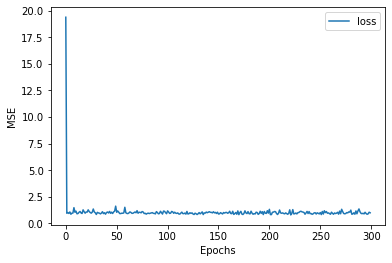

In [112]:
plt.plot(hist.history['loss'])
plt.legend(['loss'])
plt.ylabel('MSE')
plt.xlabel('Epochs')
plt.show()